In [1]:
from Shared.shared import *
from Shared.specific_CNB_sim import *
from Shared.specific_CNB_decay import *
import more_itertools

## Define parameters

In [2]:
sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"

m_light, m_mid, m_heavy = Physics.neutrino_masses(
    m_lightest=0.1*Params.eV, ordering="NO", args=Params())
m_arr =np.array([m_heavy])
m_arr_p =np.array([m_heavy])
m_arr_d = np.array([m_light])
gamma_str ='0.1T'
pix_sr=4 * Params.Pi
args=Params()

decayed_neutrinos_index_z = jnp.load(
    f'sim_output/no_gravity_decay/decayed_neutrinos_index_z_{gamma_str}.npy', allow_pickle = True)
flattened_array =list(more_itertools.collapse(decayed_neutrinos_index_z)) 

## Load vectors

In [3]:
#u_vectors_p = jnp.array(np.load(f'{sim_folder}/vectors_halo1_p_{gamma_str}.npy'))
#nu_vectors_d = jnp.array(np.load(f'{sim_folder}/vectors_halo1_d_{gamma_str}.npy'))
nu_vectors_nd = jnp.array(np.load(f'{sim_folder}/vectors_halo1.npy'))
nu_vectors_nd =nu_vectors_nd.reshape(768000, 2, 6)
print(np.shape(nu_vectors_nd.reshape(768000, 2, 6)))

nu_vectors_p= nu_vectors_nd.at[flattened_array,0,3:6].set(0)
nu_vectors_p= nu_vectors_p.at[flattened_array,1,3:6].set(0)
nu_vectors_p= nu_vectors_p.reshape((768,1000, 2, 6))

nu_vectors_d= jnp.zeros(np.shape(nu_vectors_nd))
nu_vectors_d = nu_vectors_d.at[flattened_array,0,3:6].set(nu_vectors_nd[flattened_array,0,3:6])
nu_vectors_d = nu_vectors_d.at[flattened_array,1,3:6].set(nu_vectors_nd[flattened_array,1,3:6])
nu_vectors_d =nu_vectors_d.reshape((768,1000, 2, 6))
nu_vectors_nd =nu_vectors_nd.reshape((768,1000, 2, 6))

(768000, 2, 6)


## Number Density Function

### Currently we are setting to zero initial and end momentum of the particles that have decayed or viceversa. I just use this function to get the momenta and fermi dirac distributions


In [ ]:
#@jax.jit
def number_density(p_init, p_back, pix_sr, args):
      
        """Neutrino number density obtained by integration over initial momenta.

        Args:
            p_init (array): neutrino momentum today
            p_back (array): neutrino momentum at z_back (final redshift in sim.)

        Returns:
            array: Value of relic neutrino number density in (1/cm^3).
        """    

        # note: trapz integral method needs sorted (ascending) "x-axis" array.
        ind = p_init.argsort(axis=-1)
        p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
        p_init_sort_y = jnp.copy(p_init_sort)
        p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)
        
        zero_mask_init = p_init_sort == 0
        #p_init_sort = p_init_sort.at[zero_mask_init].set(1)
         #shape should be (masses, npix,neutrinos per pixel)
      
        # Fermi-Dirac values with momenta at end of sim
        FD_arr = Physics.Fermi_Dirac(p_back_sort, args)
        fd =FD_arr
        # Calculate number density
        y = p_init_sort_y**3 * FD_arr
        y= y.at[zero_mask_init].set(0) # dlog integrand
        x = p_init_sort
        z= p_back_sort
        n_raw = trap(y, jnp.log(x), axis=-1)

        # Multiply by constants and/or solid angles and convert to 1/cm**3.
        n_cm3 = pix_sr * args.g_nu/((2*args.Pi)**3) * n_raw / (1/args.cm**3)

        return p_init_sort,y,p_back_sort, fd

## Number Density Calculation for all the different cases

In [ ]:
v_arr=jnp.array(nu_vectors_nd.reshape(-1, 2, 6)[..., 3:])
p_arr, _ = Physics.velocities_to_momenta(v_arr, m_arr, args=Params())
x,y,z,fd = number_density(
            p_arr[...,0], p_arr[...,-1], pix_sr, args=Params())

v_arr_p=jnp.array(nu_vectors_p.reshape(-1, 2, 6)[..., 3:])
p_arr_p, _ = Physics.velocities_to_momenta(v_arr_p, m_arr_p, args=Params())
x_parent,y_parent, z_parent,fd_parent= number_density(
            p_arr_p[...,0], p_arr_p[...,-1], pix_sr, args=Params())

v_arr_d=jnp.array(nu_vectors_d.reshape(-1, 2, 6)[..., 3:])
p_arr_d, _ = Physics.velocities_to_momenta(v_arr_d, m_arr_d, args=Params())
x_daughter,y_daughter, z_daughter,fd_daughter= number_density(
            p_arr_d[...,0], p_arr_d[...,-1], pix_sr, args=Params())
        

## Plotting

In [ ]:
x_parent = x_parent.reshape(768000)
y_parent = y_parent.reshape(768000)
z_parent = z_parent.reshape(768000)
fd_parent=fd_daughter.reshape(768000)

x_daughter = x_daughter.reshape(768000)
y_daughter = y_daughter.reshape(768000)
z_daughter = z_daughter.reshape(768000)
fd_daughter=fd_daughter.reshape(768000)

x  = x.reshape(768000)
y = y.reshape(768000)
z = z.reshape(768000)
fd =fd.reshape(768000)

## Integral term distribution for neutrino number

Text(0, 0.5, '$p_{final}$')

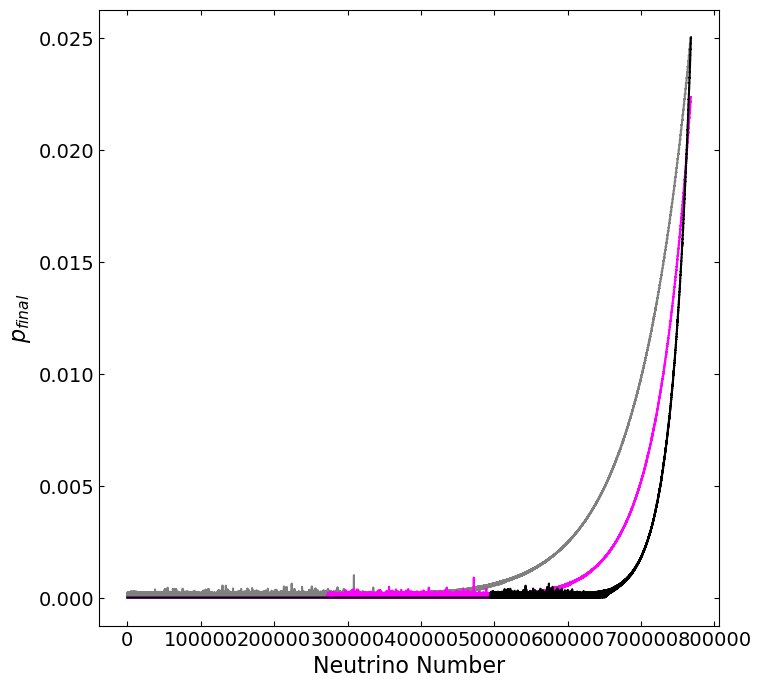

In [ ]:
plt.plot(z, label = 'No decay', color ='grey')
plt.plot(z_daughter,label = 'daughter', color ='magenta')
plt.plot(z_parent,label = 'parent', color ='black')
plt.xlabel("Neutrino Number")
plt.ylabel(r"$p_{final}$")

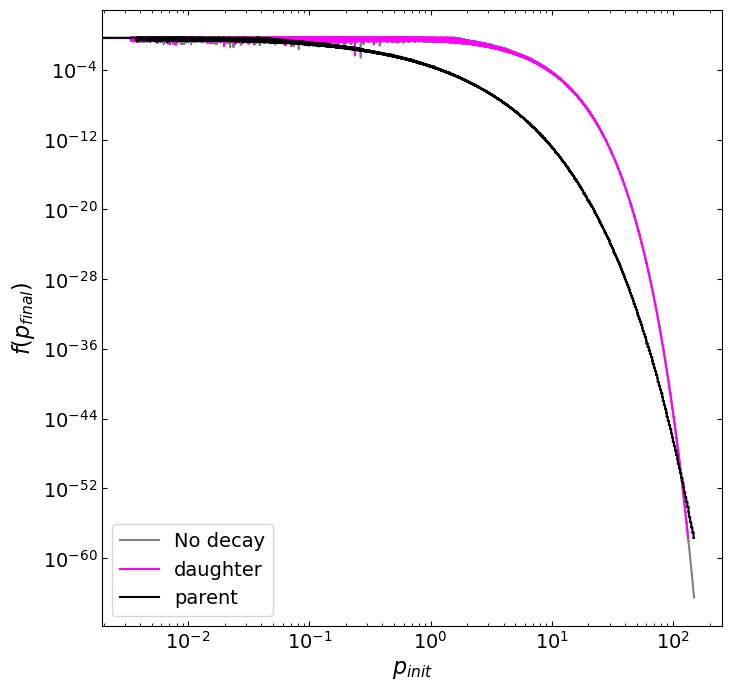

In [ ]:
plt.loglog(x/T_CNB,fd, label = 'No decay', color ='grey')
#plt.xlim(0,0.0002)
plt.loglog(x_daughter/T_CNB,fd_daughter,label = 'daughter', color ='magenta')
plt.loglog(x_parent/T_CNB,fd_parent,label = 'parent', color ='black')
#plt.xlim(0,6)
plt.xlabel(r'$p_{init}$')
plt.ylabel(r'$f(p_{final})$')
plt.legend()
plt.show()

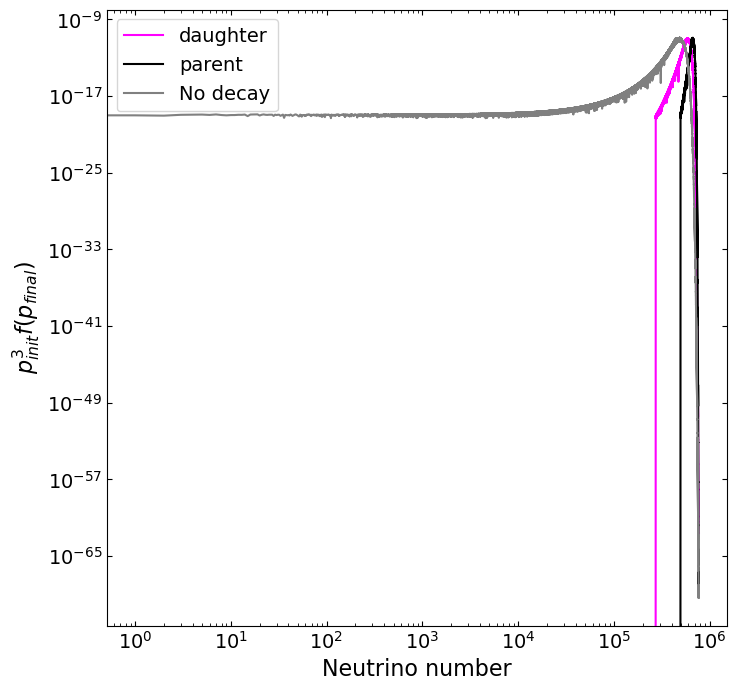

In [ ]:
plt.loglog(y_daughter,label = 'daughter', color ='magenta')
plt.loglog(y_parent,label = 'parent', color ='black')
plt.loglog(y, label = 'No decay', color ='grey')
plt.xlabel(r"Neutrino number")
plt.ylabel(r"$p_{init}^3f(p_{final})$")
plt.legend()
#plt.xlim(0,0.003)
plt.xlim(1e5,1e6)
plt.show()

##  Distribution of integration term

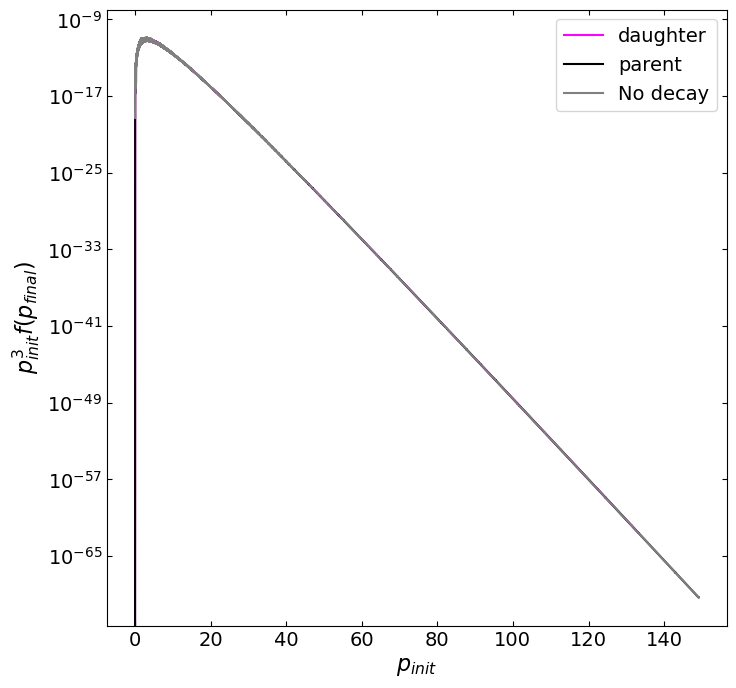

In [ ]:
plt.semilogy(x_daughter/T_CNB,y_daughter,label = 'daughter', color ='magenta')
plt.semilogy(x_parent/T_CNB,y_parent,label = 'parent', color ='black')
plt.semilogy(x/T_CNB, y, label = 'No decay', color ='grey')
plt.xlabel(r"$p_{init}$")
plt.ylabel(r"$p_{init}^3f(p_{final})$")
plt.legend()
#plt.xlim(0.0005,0.001)
plt.show()

## Distribution of the initial momentum

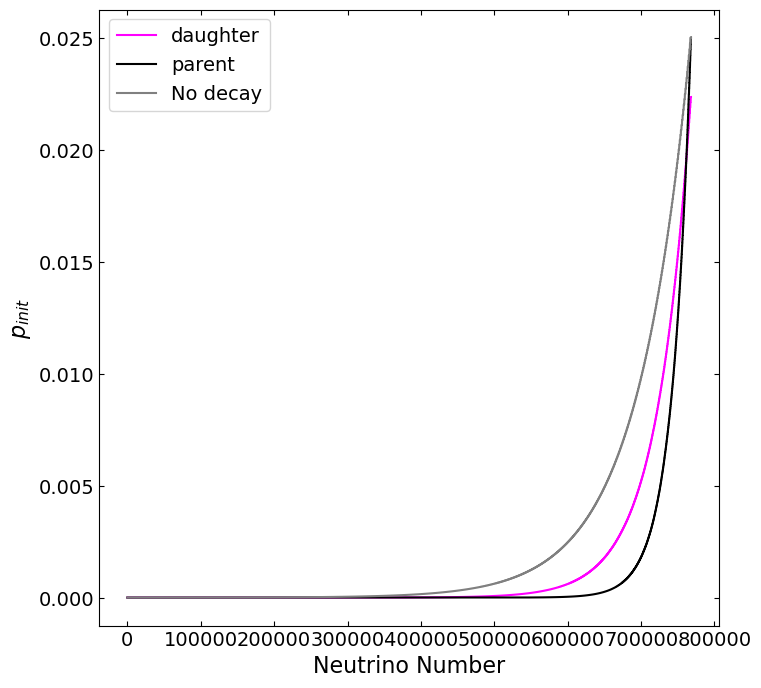

In [ ]:
plt.plot(x_daughter,label = 'daughter', color ='magenta')
plt.plot(x_parent,label = 'parent', color ='black')
plt.plot(x, label = 'No decay', color ='grey')
plt.xlabel(r"Neutrino Number")
plt.ylabel(r"$p_{init}$")
plt.legend()
#plt.xlim(0.0005,0.001)
plt.show()

## Fabians suggestion: Use his function

In [ ]:
def phase_space_2x2_FD_vs_PF(sim_dir, m_picks, halo_num, fig_dir, gamma_str, particle_str, args):

        # Load neutrino vectors for all halos
        halo_vectors = SimData.load_vectors(sim_dir=sim_dir, halo_num=halo_num)
        indices = jnp.load(f'sim_output/no_gravity_decay/decayed_neutrinos_index_z_{gamma_str}.npy', allow_pickle = True)
        flattened_array =list(more_itertools.collapse(indices))
        print(np.shape(flattened_array))
        if particle_str == 'daughter':
            halo_vectors = halo_vectors.reshape(halo_num, 768000,2,6)
            halo_vectors = halo_vectors.at[:, flattened_array,:,:].set(0)
            halo_vectors = halo_vectors.reshape(halo_num, 768,1000,2,6)
        elif particle_str == 'parent': 
            halo_vectors = halo_vectors.reshape(halo_num, 768000,2,6)
            mask = np.ones(halo_vectors.shape[1], dtype=bool)
            mask[flattened_array] = False  # Set True where flattened_array specifies positions
            # Apply the mask to set elements to 0
            halo_vectors=halo_vectors.at[:, mask, :, :].set(0)
            halo_vectors = halo_vectors.reshape(halo_num, 768,1000,2,6)
        elif particle_str == 'no_decay': 
             halo_vectors = SimData.load_vectors(sim_dir=sim_dir, halo_num=halo_num)
             
        # Convert velocities to momenta
        p_arr, y_arr = Physics.velocities_to_momenta_ND_halo_0th_axis(
            v_arr=halo_vectors[...,3:], 
            m_arr=m_picks,
            args=Params())
       
        p_z0 = p_arr[...,0]
        p_z4 = p_arr[...,-1]
        y_z0 = y_arr[...,0]
       
        
        # Sort in ascending order of momentum array today
        ind = p_z0.argsort(axis=-1)
        p_z4_sort = jnp.take_along_axis(p_z4, ind, axis=-1)
        y_z0_sort = jnp.take_along_axis(y_z0, ind, axis=-1)
        

        # x-axis
        y_z0_select = jnp.swapaxes(y_z0_sort, -1, -2)[..., 0]
        y_z0_median = jnp.median(y_z0_select, axis=0)

        # PSD using Fermi-Dirac assumption
        FD_vals = Physics.Fermi_Dirac(p_z4_sort, Params())

        # Select most (likely) clustered ones
        FD_select = jnp.max(jnp.swapaxes(FD_vals, -1, -2), axis=-1)
        
        # Compute medians and percentile ranges
        FD_median   = jnp.median(FD_select, axis=0)
        FD_perc2p5  = jnp.percentile(FD_select, q=2.5,  axis=0)
        FD_perc97p5 = jnp.percentile(FD_select, q=97.5, axis=0)
        FD_perc16   = jnp.percentile(FD_select, q=16,   axis=0)
        FD_perc84   = jnp.percentile(FD_select, q=84,   axis=0)

      
        plt.figure()
        for i in range(1):
            ax = plt.subplot(221 + i)


            ### =========== ###
            ### Fermi-Dirac ###
            ### =========== ###
            FD_color = "mediumblue"

            # Median of all halos
            ax.plot(
                y_z0_median[i], FD_median[i], 
                color=FD_color, alpha=0.7, label="Sim w/ Fermi-Dirac")

            # Percentile ranges of all halos
            ax.fill_between(
                y_z0_median[i], FD_perc2p5[i], FD_perc97p5[i],
                color=FD_color, alpha=0.2, label=r"$2.5-97.5$ % C.L.")
            ax.fill_between(
                y_z0_median[i], FD_perc16[i], FD_perc84[i],
                color=FD_color, alpha=0.3, label=r"$16-84$ % C.L.")


            ### ================================= ###
            ### Original Fermi-Dirac distribution ###
            ### ================================= ###

            p_FD = jnp.geomspace(
                args.p_start*args.T_CNB, 
                args.p_stop*args.T_CNB, 
                FD_median.shape[-1])
            y_FD = p_FD / args.T_CNB
            vals_FD = Physics.Fermi_Dirac(p_FD, args)
            ax.plot(
                y_FD, vals_FD, 
                color="magenta", ls=":", alpha=0.85, 
                label="Original Fermi-Dirac")


            ### ============ ###
            ### Plot Styling ###
            ### ============ ###

            ax.set_title(fr"PSD for $m_\nu=${m_picks[i]} eV")
            ax.set_ylim(1e-2, 1.7*1e0)
            ax.set_xlim(Params.p_start, 1e1)
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xlabel(r"$p/T_{\nu,0}$")
            ax.set_ylabel(r"$f_{\oplus,\mathrm{today}}$")
            ax.grid()

            if i==3:
                ax.legend(
                    loc='lower left', borderpad=0.5, labelspacing=0.5, 
                    fontsize='medium', prop={"size":10})

            plt.tight_layout()

        plt.savefig(f"{fig_dir}/PSD_FD_vs_PF.png", bbox_inches="tight")
        plt.savefig(f"{fig_dir}/PSD_FD_vs_PF.pdf", bbox_inches="tight")
        plt.show(); plt.close()

(495176,)


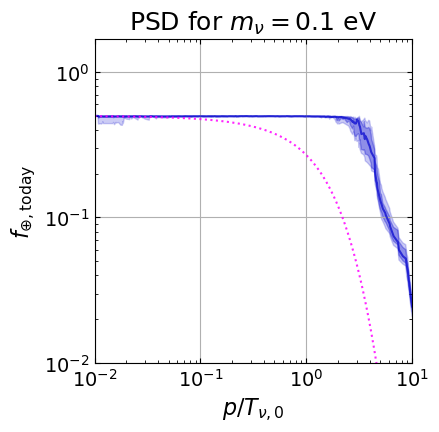

In [ ]:
phase_space_2x2_FD_vs_PF(sim_dir=sim_folder, m_picks=m_arr_d, halo_num=10, fig_dir="figures_local", gamma_str='0.1T', particle_str ='daughter', args=Params())

(495176,)


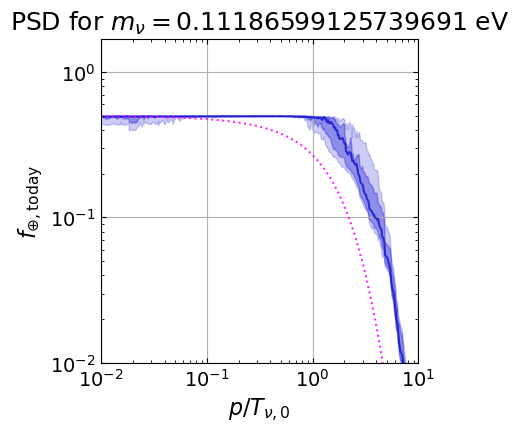

In [ ]:
phase_space_2x2_FD_vs_PF(sim_dir=sim_folder, m_picks=m_arr_p, halo_num=10, fig_dir="figures_local", gamma_str='0.1T', particle_str ='parent', args=Params())

(495176,)


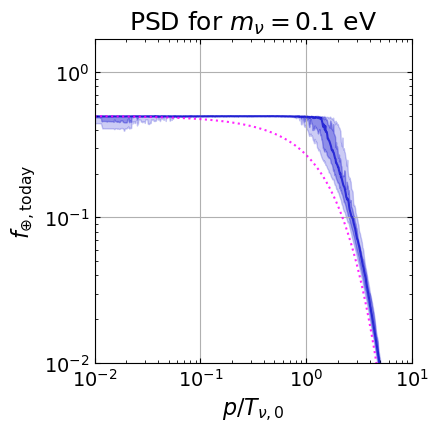

In [ ]:
phase_space_2x2_FD_vs_PF(sim_dir=sim_folder, m_picks=m_arr_d, halo_num=10, fig_dir="figures_local", gamma_str='0.1T', particle_str ='no_decay', args=Params())